# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
import matplotlib.pyplot as plt

In [4]:
import matplotlib.ticker as ticker

In [5]:
import seaborn as sns

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
import re

In [8]:
#import progressbar


In [9]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [10]:
print(portfolio.shape)
portfolio.info()

(10, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
print(profile.shape)
profile.info()

(17000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
print(transcript.shape)
transcript.info()

(306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In the below cells, I well start cleaning the data in which it serves my analysys in the nest way.

## Cleaning Data

### portfolio dataframe

There are multiple point I wish to address on this datafrme:

1- Change the name of the 'id' column to 'offer_id'

2- One hot encode the 'offer_type' column

3- One hot encode the 'channels' columns

In [15]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [16]:
 offertype_df = pd.get_dummies(portfolio['offer_type'])

In [17]:
offertype_df.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [18]:
portfolio = pd.concat([portfolio, offertype_df], axis=1)

In [19]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0


In [20]:
mlb = MultiLabelBinarizer()

channels_df = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [21]:
channels_df.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [22]:
portfolio = pd.concat([portfolio, channels_df], axis=1)

In [23]:
portfolio = portfolio.drop('channels', axis=1)

In [24]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


## Cleaning Data
### profile dataframe

There are multiple point I wish to address on this datafrme:

1- Rename id col name to customer_id.

2- drop rows with no gender, income or age data

3- Transform the 'became_member_on' column to a datetime object

4- One hot encode a customer's age range

5- Transform a customer's gender from a character to a number

In [25]:
profile.duplicated().sum()

0

In [26]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [27]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [28]:
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [29]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [30]:
profile = profile.dropna(axis=0, how='any')

In [31]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [32]:
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] = pd.cut(profile['age'], (range(min_age_limit,max_age_limit + 10, 10)), right=False)

profile['agerange'] = profile['agerange'].astype('str')

agerange_df = pd.get_dummies(profile['agerange'])

In [33]:
agerange_df.head()

,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,1,0,0,0
12,0,0,0,0,0,1,0,0,0,0


In [34]:
# Re-arrangingin the dataframe
agerange_df = agerange_df[['[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)', '[100, 110)']]

In [35]:
agerange_df.head()

,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
1,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0
12,0,0,0,0,1,0,0,0,0,0


In [36]:
(profile.gender == 'O').mean()

0.014300168634064081

In [37]:
profile.gender.unique()

array(['F', 'M', 'O'], dtype=object)

In [38]:
# Will drop the rows in profile dataframe that are neither 'M' nor 'F'
a = ['M', 'F']
profile = profile[profile['gender'].isin(a)]

In [39]:
profile.gender.unique()

array(['F', 'M'], dtype=object)

In [40]:
gender = {'M': 1,'F': 0}

profile.gender = [gender[item] for item in profile.gender]

In [41]:
profile.head()

,age,became_member_on,gender,customer_id,income,agerange
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,"[50, 60)"
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"[70, 80)"
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,"[60, 70)"
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,"[60, 70)"
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"[50, 60)"


In [42]:
# Dropping individuals in age range 100-110 because they represent a very small segemnt and won't affect the analysis
profile = profile[profile.agerange != '[100, 110)']

In [43]:
profile.agerange.unique()

array(['[50, 60)', '[70, 80)', '[60, 70)', '[20, 30)', '[40, 50)',
       '[30, 40)', '[90, 100)', '[80, 90)', '[10, 20)'], dtype=object)

In [44]:
# Checking for duplicates
profile.duplicated().any()

False

In [45]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Cleaning Data
### transcript dataframe

There are multiple point I wish to address on this datafrme:

1- Change the name of the 'person' column to 'customerid'

2- Remove customer id's that are not in the customer profile DataFrame

3- Convert time variable units from hours to days

4- Separate the dictionaries in 'value' column into two columns ('offerid'  and 'amount')

5- Pull a transactions dataframe and offers_stats dataframe

In [46]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [47]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [48]:
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [49]:
transcript['time'] /= 24.0

In [50]:
# Here I will separate the dictionaries in 'value' column into two columns 
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1).drop('value', axis = 1)

In [51]:
transcript['offerid'] = transcript[['offer_id', 'offer id']].apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis=1
)

In [52]:
transcript = transcript.drop(['offer_id', 'offer id'], axis=1)

In [53]:
transcript.sample(20)

,event,customer_id,time,amount,reward,offerid
69709,offer viewed,0cebf0c50b1f4aa7a403380b2851109b,7.25,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
160035,offer received,683cc3d7e6974945ae2b60244d3c3b80,17.00,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
214674,transaction,d24aac66f5404bc48728a207cee8b098,21.00,31.28,NaN,
175294,offer completed,3144307f20fa4971ad796f6839058e18,17.75,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2
267600,offer viewed,9bef230231ff4a1899b5b8e7214bff42,24.50,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
202953,offer received,64debcaed4a14d6997444bbecb27b055,21.00,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
155267,offer received,5bfda10afe2846a6980b72988b28d144,17.00,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
24017,offer viewed,3d3bad0437e3459d873772f8023653ac,1.00,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
97355,transaction,6e7a3b3499324084b562ca674d681f81,10.75,5.78,NaN,
216534,offer viewed,f64f9645524f493d83956f3211bb4c2d,21.00,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2


In [54]:
transcript.duplicated().sum()

368

In [55]:
transcript.drop_duplicates(keep='first', inplace=True)

In [56]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offerid', 'event'], inplace=True)
transaction_df

,customer_id,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,0.00,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,0.00,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97,NaN
12678,629fc02d56414d91bca360decdfa9288,0.00,33.90,NaN
12687,a97e6f33219c432db82acfa0d19c602d,0.00,18.59,NaN
12691,676506bad68e4161b9bbaffeb039626b,0.00,18.01,NaN
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11,NaN
12706,4cbe33c601a5407f8202086565c55111,0.00,36.19,NaN


In [57]:
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [58]:
offers_df

,customer_id,time,reward,offerid,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.00,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
9,31dda685af34476cad5bc968bdb01c53,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
12,4b0da7e80e5945209a1fdddfe813dbe0,0.00,NaN,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
13,c27e0d6ab72c455a8bb66d980963de60,0.00,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0
14,d53717f5400c4e84affdaeda9dd926b3,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
15,f806632c011441378d4646567f357a21,0.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


## Exploratory Data Analysis

In [59]:
profile.head()

,age,became_member_on,gender,customer_id,income,agerange
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,"[50, 60)"
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,"[70, 80)"
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,"[60, 70)"
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,"[60, 70)"
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,"[50, 60)"


In [60]:
transcript.head()

,event,customer_id,time,amount,reward,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [61]:
transaction_df.head()

,customer_id,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,0.0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97,NaN


In [62]:
offers_df.head()

,customer_id,time,reward,offerid,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


### Compute what percent of customers are in each age range

In [63]:
ages_count = profile['agerange'].value_counts()

ages_count *= 100 / ages_count.sum()
ages_count

[50, 60)     23.874769
[60, 70)     20.223334
[40, 50)     15.544290
[70, 80)     12.036720
[30, 40)     10.296636
[20, 30)      9.269028
[80, 90)      5.624443
[90, 100)     1.726382
[10, 20)      1.404398
Name: agerange, dtype: float64

In [64]:
ages_array = profile.loc[:, 'agerange']

In [65]:
labels, counts = np.unique(ages_array, return_counts=True)

### Plotting age range distribution and income destribution of all customers

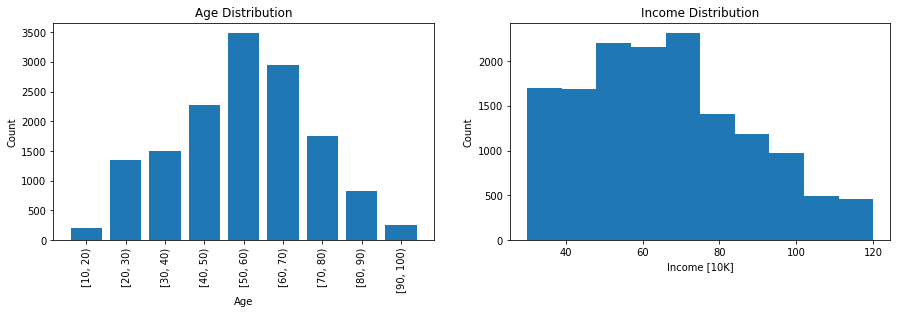

In [66]:
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

plt.sca(ax[0])
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.xticks(rotation=90)

plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3 )
plt.xlabel('Income [10K]')
plt.ylabel('Count')
plt.title('Income Distribution');

Age distribution plot depicts that the median age range of a customer is 50-60 and most of our customers belong to age range between 40 to 70. Income distribution plot shows that the number of customers whose average salary is less than 70K is high than the other side considering 70K to be median of the income distribution. 

### Plotting income differences as a function of gender

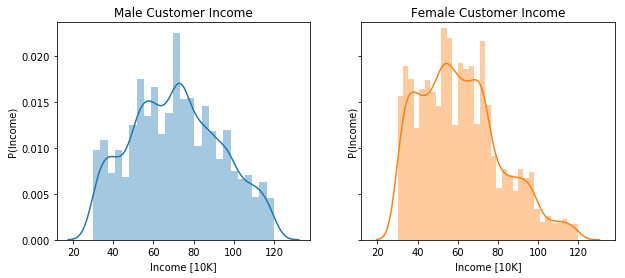

In [67]:
current_palette = sns.color_palette()
# extract male and female customers
male_customers = profile[profile['gender'] == 0]
female_customers = profile[profile['gender'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3, color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income');

plots conclude that minimum and maximum income for both male and female are approximately same but the count of male customers in low-income level is slightly higher than that of female customers

### Plotting age ranges as a function of gender

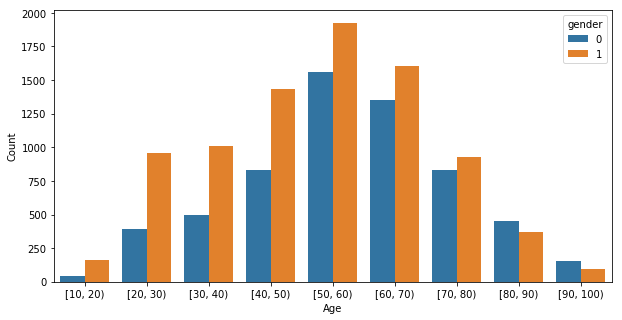

In [68]:
# groupby start_year and gender to plot a graph
age_range = profile.groupby(['agerange', 'gender']).size()
age_range = age_range.reset_index()
age_range.columns = ['agerange', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age')
plt.ylabel('Count');

The above bar plot shows that the males (0) have more presense than females (1) across most of the age range categories

### Combine offer, profile and transactions dataframes

Next, I will combine 3 dataframes applying the following steps:

1-Select a customer's profile

2-Select offer data for a specific customer

3-Select transactions for a specific customer

4-Initialize DataFrames that describe when a customer receives, views, and completes an offer

5-Iterate over each offer a customer receives

For each offer id, our main goal is to find out if the offer is successful by deciding if a customer reacts to an offer within the offer validity time period

In [69]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offerid']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
            
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [70]:
#data = combine_data(profile, portfolio, offers_df, transaction_df)

In [71]:
#data.columns

In [72]:
#column_ordering = ['time', 'offer_id', 'customer_id', 'total_amount',
                   #    'offer_successful', 'difficulty', 'duration', 'offer_type',
                    #   'reward', 'bogo', 'discount', 'informational',
                     #  'email', 'mobile', 'social', 'web', 'gender', 'agerange',
                      # 'income', 'became_member_on', ]
#data = data[column_ordering]

In [73]:
#data.head()

In [74]:
#data.shape

In [75]:
#data.to_csv('master_offer_analysis.csv', index=False)

In [76]:
data = pd.read_csv('master_offer_analysis.csv')

In [77]:
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [78]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,difficulty,duration,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,6551,75.270951,10,10,discount,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6560,72.743902,7,7,discount,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,6481,61.425706,5,5,bogo,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,6585,54.502658,10,7,bogo,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6514,51.565858,10,5,bogo,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6581,47.986628,5,7,bogo,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,6531,47.496555,10,7,discount,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6620,45.513595,20,10,discount,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,6553,7.736914,0,4,informational,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,6538,6.133374,0,3,informational,0,0,0,1,1,1,1,0


Text(0,0.5,'Percentage')

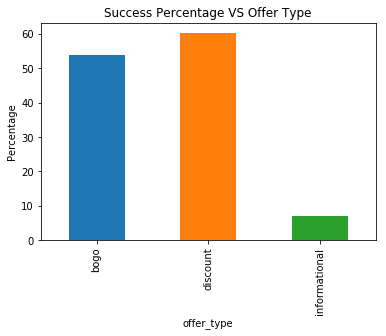

In [79]:
percent_success.groupby('offer_type')['percent_success'].mean().plot(kind='bar')
plt.title('Success Percentage VS Offer Type')
plt.ylabel('Percentage')

We notice from the above bar plot that the "discount" offer type gets the highest success percentage in terms of customers reactions to promotions. In the below bar plot, I illustrate how the duration of the promotion affects the it's success, it is only notable in the "buy one get one" offer type where shorter durations lead to more success.

Text(0,0.5,'Percentage')

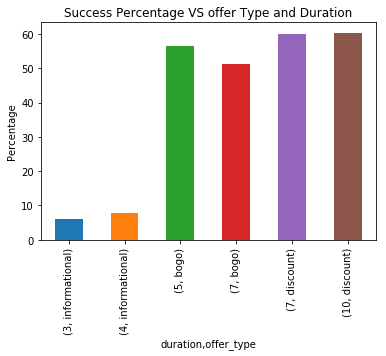

In [80]:
percent_success.groupby(['duration', 'offer_type'])['percent_success'].mean().plot(kind='bar')
plt.title('Success Percentage VS offer Type and Duration')
plt.ylabel('Percentage')

In [81]:
gender_age = data.groupby(['agerange', 'gender'])['offer_successful'].mean()

Text(0,0.5,'Success mean')

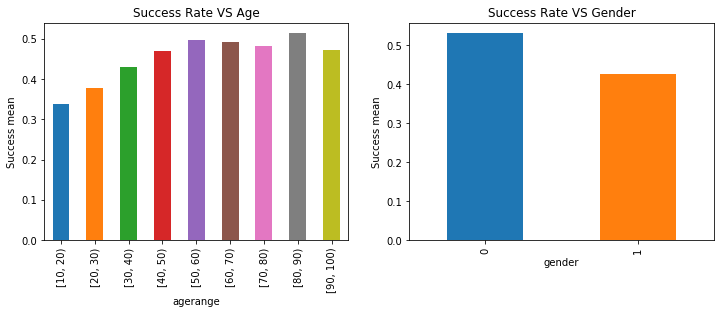

In [82]:
fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(1,2,1)
data.groupby('agerange')['offer_successful'].mean().plot(kind='bar')
plt.title('Success Rate VS Age')
plt.ylabel('Success mean')

plt.subplot(1,2,2)
data.groupby('gender')['offer_successful'].mean().plot(kind='bar')
plt.title('Success Rate VS Gender')
plt.ylabel('Success mean')

From the above bar plots, we notice that customers of ages between (80-90) and (50-60) are the most reacting to various types of offers, and offers are showing more success when they are sent to females rather than males

In [83]:
data.columns

Index(['time', 'offer_id', 'customer_id', 'total_amount', 'offer_successful',
       'difficulty', 'duration', 'offer_type', 'reward', 'bogo', 'discount',
       'informational', 'email', 'mobile', 'social', 'web', 'gender',
       'agerange', 'income', 'became_member_on'],
      dtype='object')

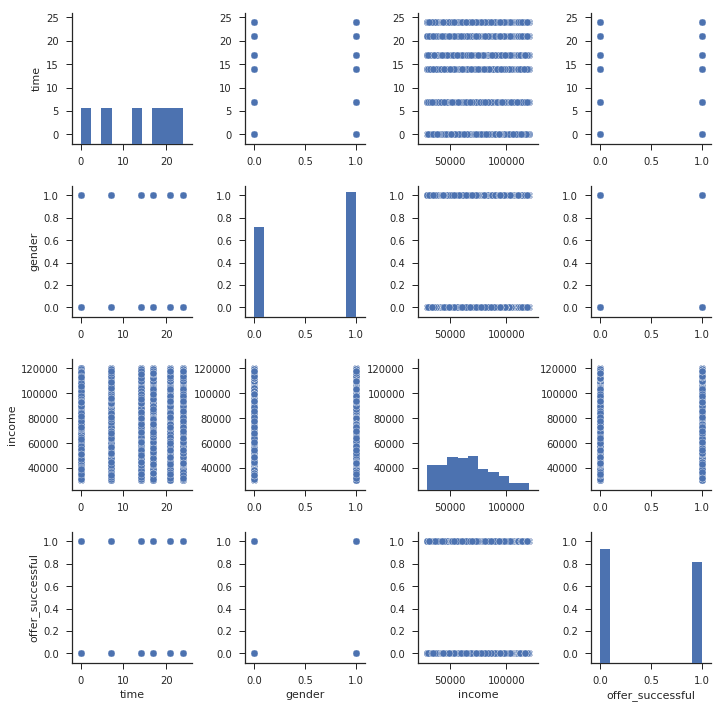

In [84]:
col = ['offer_type', 'time', 'gender', 'income', 'agerange', 'offer_successful']
sns.set(style="ticks", color_codes=True)
sns.pairplot(data[col].dropna())
plt.show();

## Building models

In [85]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [86]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [87]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [88]:
data.columns

Index(['time', 'offer_id', 'customer_id', 'total_amount', 'offer_successful',
       'difficulty', 'duration', 'offer_type', 'reward', 'bogo', 'discount',
       'informational', 'email', 'mobile', 'social', 'web', 'gender',
       'agerange', 'income', 'became_member_on'],
      dtype='object')

Having all the features related to offer id and customer id, we can drop these columns withput having as affect on our models that we are going to build

In [89]:
data_model = data.drop(['offer_id', 'customer_id', 'offer_type'], axis=1)

In [90]:
data.select_dtypes(include=['object']).copy().columns

Index(['offer_id', 'customer_id', 'offer_type', 'agerange',
       'became_member_on'],
      dtype='object')

In [91]:
# Will produce dummy variables od the 'agerange' column
data_model = pd.concat([data_model.drop('agerange', axis=1), pd.get_dummies(data_model['agerange'], drop_first=True)], axis=1)

In [92]:
# Will edit the 'became_member_on' column to contain only the year
data_model['became_member_on']=pd.to_datetime(data_model['became_member_on'], format='%Y-%m-%d')

In [93]:
data_model['became_member_on'] = data_model['became_member_on'].dt.year

In [94]:
data_model.head()

,time,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,informational,email,...,income,became_member_on,"[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0.0,37.67,1,5,7,5,1,0,0,1,...,100000.0,2017,0,0,0,0,0,1,0,0
1,7.0,49.39,0,0,3,0,0,0,1,1,...,100000.0,2017,0,0,0,0,0,1,0,0
2,17.0,48.28,1,10,7,10,1,0,0,1,...,100000.0,2017,0,0,0,0,0,1,0,0
3,21.0,48.28,1,5,5,5,1,0,0,1,...,100000.0,2017,0,0,0,0,0,1,0,0
4,0.0,0.00,0,10,7,2,0,1,0,1,...,70000.0,2018,0,0,0,0,1,0,0,0


In [95]:
features = data_model.drop(columns=['offer_successful'])

label = data_model.filter(['offer_successful'])

X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [96]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  35.4s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  35.9s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=  36.3s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   4.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   4.2s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  1.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=6, n_jobs=3,
          param_distributions={'penalty': ['l1', 'l2'], 'C': [1.0, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [97]:
def evaluate(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

### Evauating performance on training data

In [98]:
evaluate(lr_random, X_train, y_train)

RandomizedSearchCV model accuracy: 0.879
RandomizedSearchCV model f1-score: 0.866


(0.87856255042630671, 0.86581692889670636)

### Evaluating performance on test data

In [99]:
evaluate(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.884
RandomizedSearchCV model f1-score: 0.870


(0.88364283897227169, 0.87018221036498844)

The logistic regression classifier perfromance seems pretty good, but I would also try implementing RandomForestClassifier on our data and tune it using RandomizedSearchCV and see how it performs

In [100]:
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   1.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.7min


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   4.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   6.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9, total=  18.5s
[CV] n_estimators=150, min_samples_split=10, min_samples_leaf

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  9.9min


[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   7.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=9 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5, total=   5.6s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 19.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

### Evaluating performance on training data

In [101]:
evaluate(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.941
RandomForestClassifier model f1-score: 0.938


(0.94094943195446912, 0.93827779550531065)

### Evaluating performance on test data

In [102]:
evaluate(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.920
RandomForestClassifier model f1-score: 0.915


(0.91966420758076828, 0.91529424387103697)

## Conclusion

The problem that I tried to address was to build a model that predicts whether a customer will respond to an offer (offer being successful) based on multiple features of the offers themselves and the customers that are contacted. My strategy for solving this problem has mainly two steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of a logistic regression model. Third, I compared the performance of logistic regression and random forest models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. Analysis suggests that random forest model has a training data accuracy of 0.94 and an F1-score of 0.93. The test data set accuracy of 0.92 and F1-score of 0.915 suggests that the random forest model I constructed did not overfit the training data.

Better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about customer available to us — just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results.